In [40]:
from os.path import isfile, isdir
import csv
import pickle

#读取视频文件
def loadmkv(file,imgnum=10):
    import cv2
    cap = cv2.VideoCapture(file +'_front.mkv')
    ret = True
    frame_list = []
    i = 1 
    while(ret == True):
        ret, frame = cap.read()
        if (ret == True):
            frame_list.append(frame)
            del frame
            if (i>=imgnum):
                break
            i = i + 1
            #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            #cv2.imshow('frame',gray)
    
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    
    labels_list = []
    i = 1
    with open(file + '_steering.csv', encoding='utf-8') as csvfile:
        csv_reader = csv.DictReader(csvfile)
        for row in csv_reader:
            labels_list.append(row['wheel'])
            if (i>=imgnum):
                break
            i = i + 1
    return (frame_list,labels_list)

epochs_path = '/epochs/'
for i in range(1,2):
    filename = epochs_path + 'epoch0' + str(i)
    if not isfile(filename + '.p'):
        features,labels = loadmkv(filename,1499)
        with open('/output/'+ 'epoch0' + '.p', 'wb') as outputfile:
            pickle.dump((features,labels), outputfile)
        del features,labels
print('load file completion')

load file completion


In [28]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        x,y = pickle.load(fo, encoding='bytes')
    return x,y

100


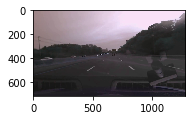

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing import image
import numpy as np

x,y = unpickle('/epochs/epoch01.p')
from matplotlib import pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
for i in range(len(x)):
    ax.imshow(x[i])  